# The Max-cut problem.

### Introduction.

We can define a graph as a a set of elements, and the relations between them. Intuitivelly and graphically, we have a set of nodes, represented as a series of points distributed in the space, and the vertices, or edges, as the representation of relations between the nodes visualized as lines that connect the nodes and that in a mathematical rigorous point of view can be considered as a set of ordered pairs between the nodes.  

The Max-cut problem is a combinatorial related to get partitions of the set of nodes in a graph. We are looking for a partition of the nodes that can have maximized the number of edges between the elements of each set of the partition. Another way that can be stated this problem is in terms of colouring the nodes of the graph. Let us suppose we have a graph, and we want to assign one between two colors (let's think on white and black) to all of its nodes in the manner that each white node is to be connected to black nodes as much as possible. In other words, the problem consists in the maximization of the number of edges that have ending nodes different-coloured.  

To begin to get some insight in these concepts, let's define a class of Graphs and methods to visualize them:

In [1]:
import networkx as nx                     # Auxiliar Library to define graphs 
from matplotlib import pyplot as plt      # Library to plot the graphs

In [2]:
class Edge:
    """
    We construct the class Edge that has defined two ending nodes and an associated weight (as defect this is 1)
    """
    def __init__(self, start_node, end_node, weight = 1):
        self.start_node = start_node
        self.end_node = end_node
        self.weight = weight
        
class Graph():
    """
    Class that defines a Graph as a set of nodes and Edges.
    """
    def __init__(self, edges_set):
        self.edges_set = edges_set
        self.node_set = []
        # We get the set of nodes from the Edges set:
        for i in edges_set:
            if (i.start_node not in self.node_set):
                self.node_set.append(i.start_node)
            if (i.end_node not in self.node_set):
                self.node_set.append(i.end_node)

With the aim to watch the working of these clases, we can define and plot an example of a graph:

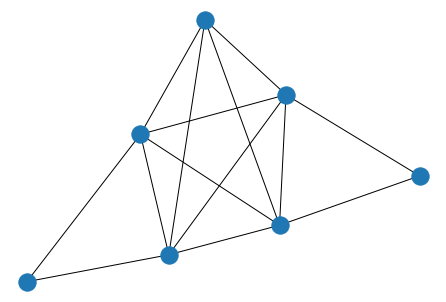

In [3]:
set_edges = [Edge(0, 1), Edge(1, 2), Edge(2, 3), Edge(3, 0), Edge(2, 0), Edge(1, 3), Edge(0, 4), Edge(1, 4),
            Edge(2, 4), Edge(3, 4), Edge(4, 5), Edge(5, 0), Edge(2, 6), Edge(6, 3)]

G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node), weight = z.weight)

nx.draw(G)
plt.show()

In fact, we can also define a method to coloured graphs:

In [4]:
def coloured_Graph(Graph, code):
    """
    Method to plot coloured graphs.
    Params:
    Graph (nx.Graph() object): Graph to be coloured.
    Code (List): binary code to color the Graph
    """
    colors = []
    for i in code:
        if i == 0:
            colors.append('green')
        else:
            colors.append('red')            
            
    pos = nx.spring_layout(Graph, seed = 100)
    nx.draw(Graph, pos, node_color = colors)
    labels = nx.get_edge_attributes(Graph, 'weight')
    nx.draw_networkx_edge_labels(Graph, pos, edge_labels = labels)
    plt.show
    
    return None

Now we can have a coloured Graph with also its respective weights:

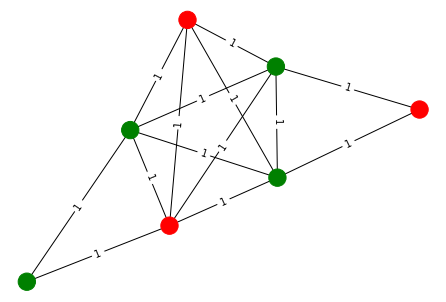

In [5]:
coloured_Graph(G, [0, 1, 0, 1, 0, 1, 0]) 

As we will need binary codes, we write an algorithm to convert decimal numbers to binary ones using a determined number of bits:

In [6]:
def Binary(number, bits):
    """
    Gives the binary representation of decimal number in bits number of bits
    
    Params:
        number(positive integer) = number to be converted 
        num(positive integer) = number of bits involved  (we assume that 0 <= number <= 2^bits-1)
    """
    list = []
    if number == 0:
        for i in range(0, bits):
            list.append(0)
    elif number == 1:
        for i in range(0, bits - 1):
            list.append(0)
        list.append(1)
    elif number == 2:
        for i in range(0, bits - 2):
            list.append(0)
        list.append(1)
        list.append(0)
    else:
        aux_list = []
        aux_number = number
        while aux_number // 2 > 1:
            aux_list.append(aux_number % 2)
            aux_number = aux_number // 2
        aux_list.append(aux_number % 2)
        aux_list.append(1)
        for j in range(0, bits):
            if j < bits - len(aux_list):
                list.append(0)
            else:
                k = j - (bits - len(aux_list))
                list.append(aux_list[len(aux_list) - k - 1])
    return list

This function, for instance, can give us the representation of the decimal number $18$ using $7$ bits:

In [7]:
Binary(18, 7)

[0, 0, 1, 0, 0, 1, 0]

We can define a generalized version of the Max Cut problem regarding weighted edges, in which our objective will be to get a cut in the graph that maximizes the total weight. The approach that we will follow is using the general ideas of the Quantum Simulation to arrive to an algorithm that allows us to solve the weighted Max Cut problem using the Circuit model of Quantum Computing, the adiabatic theorem and ideas related to Statistical Mechanics (specifically the Ising model) to solve the problem. 

## The QAOA Algorithm.

### The Adiabatic Approximation.

The adiabatic approximation is an outstanding result in Quantum Mechanics that states that if a Hamiltonian has a sufficiently slow evolution or perturbation and a physical system was at the beginning in its ground state, then the system will remain in the ground state of the perturbed Hamiltonian. Intuitively we can think that if we have a Hamiltonian that depends on a certain set of parameters and we have also its spectrum, changes slow enough of the set of parameters will be traduced in subsequent redistribution of the spectrum of the succesive Hamiltonians in a smooth fashion.  

The application condition of the adiabatic approximation is that the characteristic time os change of the Hamiltonian would be much slower than the characteristic time of the transitions between eigenstates of the Hamiltonian itself, whose frequencies are determined by the inverse of the energy gap between the states. In this way, we can consider a convex combination of two Hamiltonians:

$$H=\xi H_{C}+(1-\xi)H_{M},\qquad 0\leq\alpha\leq 1.$$

In this case, the parameter $\xi$ is a time dependent one that counts for the slow change of the Hamiltonian, starting from $H_{M}$ setting  $\xi=0$ and evolving until $H_{C}$ setting $\xi=1$. This type of Hamiltonian has the following advantage: Let's imagine that we set a physical system in the ground state of the Hamiltonian $H_{M}$, then, we let the adiabatic parameter $\xi$ going from $0$ to $1$ slowly enough, then, our system ends in the ground state of the Hamiltonian $H_{C}$.   

### The Quantum Approximation Algorithm.

The QAOA (Quantum Approximate Optimization Algorithm) allows us to solve the Max-cut problem using a circuit-gate implementation and the adiabatic approximation. The fundamental observation is that the solution of the Max-cut problem can be represented as the ground state of the Hamiltonian: $$H_{C}=\frac{1}{2}\sum_{ij}w_{ij}\left(Z_{i}Z_{j}-1\right)$$, where $Z_{i}$ is defined as the Pauli-$Z$ gate of the $i-$th qubit (in or implementation we will use a qubit for each node of the graph) and $w_{ij}$ are the associated weights of the edges. 

The idea of the algorithm is to set a physical system (a set of qubits, one for each node of our graph) into the ground state of a known Hamiltonian $$H_{M}$$. In our case, we will use the Mixer Hamiltonian: $$H_{M}=\sum_{n}X_{n}$$, where the sum is over the set of qubits of the circuit. Let's remember that the $X$ Pauli operator shifts the states $|0\rangle\leftrightarrow|1\rangle$ in the computational basis, then, if we need to set an eigenstate of such operator, for instance $|010\rangle$, it must also be present in a superposition the state $|101\rangle$. This tells us that the state $$|\psi\rangle=-\sum_{x=0}^{2^{n}-1}|x\rangle$$ is the ground state of this Mixer Hamiltonian $H_{M}$. Bearing this in mind, the QAOA algorithm follows the following steps:

1- Prepare a set of $n$ qubits in the state $|0\rangle$.

2- Apply the Hadamard transformation $H^{\otimes n}$ with the aim to obtain the superposition state $|\psi\rangle$.

3- Simulate the time evolution operator $U(\tau)=e^{-i\tau H}$.

4- Measure the qubits in the computational basis.

5- From the statistics determine the color code as the solution of the Max-Cut problem.

### The simulation of Time - Evolution operators.

The last step $3$ requires a little more comment. 

The first thing that we need to note is that $[H_{C},H_{M}]\neq 0$, which means that an analytic calculation of the time evolution operator $U(\tau)$ is in general a very hard problem. Nevertheless, we have a tool known as the Suzuki-Trotter expansion with which we can overcome the problem of this calculation and instead make it in a numerical fashion. The expansion lies in the fact that if we discretize the time in an infinitesimal way, all the operators commute. Formally, we have that: $$\lim_{n\to\infty}\left(e^{iAt/n}e^{iBt/n}\right)^{n}=e^{i(A+B)t}$$.

Then, basically instead of calculating directly the time evolution operator, we apply time-infinitesimal versions of them alternatively as a way to approximate it. But in fact, we can make it even better. We can define a cost function (the energy of the Hamiltonian $H_{C}$) dependent of the time-infinitesimal steps and make gradient-descent type updates of the parameters until reach the minimum, a procedure that has been proven much more effective for instance, in the simulation point of view of the Grover's searching algorithm (Nielsen-Chuang).

### Implementation of the Circuit of Simulation.

We begin with the implementation of the quantum circuit using Cirq:

In [8]:
import cirq                            # Quantum Circuits Library
import numpy as np
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize    # Optimization Library

num = 5      # Number of qubits to be used in the circuit
depth = 50   # Number of Repetitions of the Suzuki-Trotter Algorithm
rep = 10000  # Number of Quantum runs to get the statistics of measurements of the Quantum Circuit
set_edges = [Edge(0, 1, 5), Edge(0, 2, 1), Edge(1, 2, 7), Edge(1, 3, 4), Edge(2, 3, 2), Edge(3, 4, 3)]

qubits = [cirq.GridQubit(0, i) for i in range(0, num)] # List of Qubits



def initialization(qubits):
    """
    Initialization of the qubits in an equal superposition of the computational basis (ground state of the auxiliar Hamiltonian)
    Params:
    
    qubits(list of qubits object)
    """
    for i in qubits:
        yield cirq.H.on(i) # Application of the Hadamard gate to obtain an equal superposition of the computational basis.

Now, we can define the time evolution operators of the Hamiltonians $H_{C}$ (with time parameter $\gamma/\pi$) and $H_{M}$ (with time parameter $\alpha/\pi$):

In [9]:
# Defines the cost unitary

def cost_unitary(qubits, gamma):
    for i in set_edges:
        yield cirq.ZZPowGate(exponent = -1 * i.weight * gamma/math.pi).on(qubits[i.start_node], qubits[i.end_node])

# Defines the mixer unitary

def mixer_unitary(qubits, alpha):
    for i in range(0, len(qubits)):
        yield cirq.XPowGate(exponent = -1 * alpha/math.pi).on(qubits[i])

After this, we can create a function that executes our circuit over multiple trials, and outputs lists of the bitstrings that were measured:

In [10]:
# Executes the circuit

def create_circuit(params):

    gamma = [params[2 * i] for i in range(0, depth)]
    alpha = [params[2 * i  + 1] for i in range(0, depth)]
    
    circuit = cirq.Circuit()
    circuit.append(initialization(qubits))
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, alpha[i]))
    circuit.append(cirq.measure(*qubits, key='x'))
#    print(circuit)

    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=rep)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, rep):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)

    return new_res

Now, we are able to create our cost function, in order to post-process the data measured from the quantum circuit executions. Since the values that are ouputted from the circuit are $0$s and $1$s, instead of the desired $1$ and $-1$ values. Thus, in the place of $c_{n}$, we defined a function $f(x)=1-2x$, which maps $0$ to $1$ and $1$ to $-1$:

In [11]:
# Defines the cost function

def cost_function(params):

    av = create_circuit(params)
    total_cost = 0
    for i in range(0, len(av)):
        for j in set_edges:
            total_cost += 0.5 * j.weight * ( ( (1 - 2*av[i][j.start_node]) * (1 - 2*av[i][j.end_node]) ) - 1)
    total_cost = float(total_cost)/rep

#    print("Cost: "+str(total_cost))

    return total_cost

This function outputs the expected value of the cost function (calculate the average cost over $1000$ repetitions of the algorithm). Finally, we can define a classical optimizer to tune the $\gamma$ and $\alpha$ parameter until we arrive at a minimum expected value of the cost function. Along with the cost function, we write a bit of code that allows us to graph the results:

[9, 21, 8, 13, 22, 25, 27, 10, 26, 6, 23, 4, 28, 5, 19, 20, 18, 12, 3, 24, 17, 11, 7, 14, 15, 0, 31, 16, 30, 1]
[0.2692, 0.0673, 0.0271, 0.0124, 0.2839, 0.0576, 0.0108, 0.0704, 0.0091, 0.0626, 0.0278, 0.0103, 0.0081, 0.0101, 0.0075, 0.0053, 0.0144, 0.0061, 0.0081, 0.0063, 0.0058, 0.0059, 0.0043, 0.005, 0.0008, 0.0008, 0.0014, 0.0007, 0.0004, 0.0005]


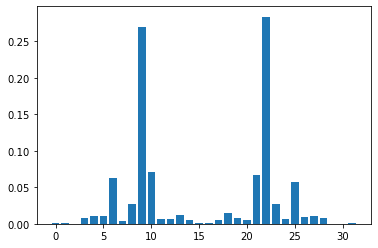

In [12]:
# Defines the optimization method

init =[float(random.randint(-314, 314))/float(100) for i in range(0, 2 * depth)]
out = minimize(cost_function,
               x0 = init, 
               method = "COBYLA", 
               options = {'maxiter' : 500}
              )
#print(out)

optimal_params = out['x']
f = create_circuit(optimal_params)

# Creates visualization of the optimal state

nums = []
freq = []

for i in range(0, len(f)):
    number = 0
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq]

print(nums)
print(freq)

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.bar(x, y)
plt.show()

The measurements gave us as results the numbers $9$ and $22$ as solutions of the Max-Cut problem in the Graph defined before. Its binary representations give us the colour code with which we can plot our solution:

In [13]:
max_value = max(y)
max_value = y.index(max_value)

In [14]:
G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node), weight = z.weight)

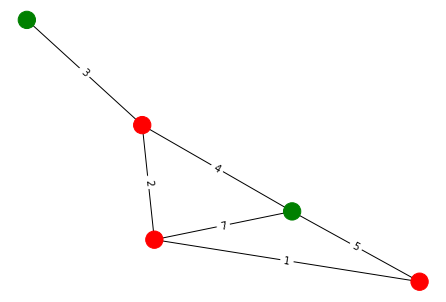

In [15]:
coloured_Graph(G, Binary(max_value, num))